# Recommendations Systems
## Assignment 2: Content Based Recommendations 

**The goal of this assignment is to:**
- Understand the details of content based recommender systems
- Understand pros&cons comparing to other recommender system approaches
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- English only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homwork needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6 should be used.  
- You should implement the recommender system by yourself using only basic Python libraries (such as numpy).


**Grading:**
- Q1 - 10 points - Data exploration
- Q3 - 30 points - Item similarity
- Q4 - 40 points - Content based recommendation  
- Q5 - 20 points - Content based vs. matrix factorization comparison

`Total: 100`

**Prerequisites**

In [1]:
!pip install --quiet zipfile36
!pip install --quiet wordcloud

**Imports**

In [2]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from wordcloud import WordCloud, STOPWORDS

# metrics - do not use these metrics, but you can use them to check your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# distance
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

# notebook
from IPython.display import FileLink, display

#additional
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations
from PIL import Image

**Hide Warnings**

In [3]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [5]:
random.seed(123)

# Question 1: 
# Data exploration 

In this exercise you will use the same dataset that we used for exercise #1:  [MovieLens 100K rating dataset](https://grouplens.org/datasets/movielens/100k/)  use Fold #2

Include additional exploration that is relevant for content based recommendation.  
Explore at least 3 features, one of the features should be text (e.g. movie title). 

Use plots and discuss your insights and possible challenges related to the dataset.


## Data Loading

In [6]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

In [7]:
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['item_id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']
cols_genres=['unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

In [8]:
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)

In [9]:
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)

In [10]:
df_folds = {i:
       {'train' : pd.read_csv('{}u{}.base'.format(data_dir,i), delimiter='\t', header=None, names=cols_data),
        'test'  : pd.read_csv('{}u{}.test'.format(data_dir,i), delimiter='\t', header=None, names=cols_data)
       } for i in range(1,6)} 

def fold2df(i):
    train = df_folds[i]['train'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    test  = df_folds[i]['test'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    return train,test 

def getfulldf(train_fold,test_fold):
    train = ratings.copy()
    train[:] = 0
    test = train.copy()
    
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    return train,test

fold = 2
train, test = getfulldf(*fold2df(2))

train.shape,test.shape

((943, 1682), (943, 1682))

## Data Prep

In [11]:
#data prep for exploration
for col in cols_genres:
    df_items[col].replace(1,col,inplace=True)

#extracting geners comination colum per item
df_genres=df_items[cols_genres].replace(0,np.NAN)
 
df_genres['genres_agg'] = df_genres.apply(lambda x: x.str.cat(sep=' '), axis=1)
df_items['genres_agg']=df_genres['genres_agg']
df_movies=df_items

#extracting titles
df_movies['title'] = [x.split('(')[-0] for x in df_movies['movie_title']]
df_movies['title']=df_movies['title'].str.lower()
df_movies.title=df_movies.title.replace('&','',regex=True).astype(str)

#creating dedicated features_vector column
df_movies['features_vector']=df_movies['genres_agg']+[' ']+df_movies['title']

data=pd.merge(df_ratings,df_movies,on='item_id',how='left')

#replace back
for col in cols_genres:
    data[col].replace(col,1,inplace=True)


## Genres exploration

Initialy lets remember from previous assignment genres distribution by #ranks 

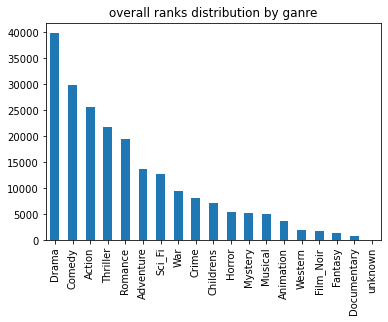

In [12]:
data[cols_genres].sum().sort_values(ascending=False).plot(kind='bar', fontsize=10)
plt.title('overall ranks distribution by ganre')
plt.show()

Lets have a look on rate expected value per genre

In [13]:
df_exp=data.copy()
for col in cols_genres:
    df_exp[col]=df_exp[col]*df_exp['rating']
    
df_exp=df_exp.replace(0,np.nan)
print('Rating per genre')
df_exp[cols_genres].mean().sort_values(ascending=False)

Rating per genre


Film_Noir      3.921523
War            3.815812
Drama          3.687379
Documentary    3.672823
Mystery        3.638132
Crime          3.632278
Romance        3.621705
Western        3.613269
Animation      3.576699
Sci_Fi         3.560723
Musical        3.521397
Thriller       3.509007
Adventure      3.503527
Action         3.480245
Comedy         3.394073
Childrens      3.353244
Horror         3.290389
Fantasy        3.215237
unknown        3.200000
dtype: float64

We would like to add another dimension which includes all possible genres combinations per item (item can have multiple genres tags) , based on the assumption that there is a difference between movie that rank with spesific genre to a movie that ranked with multiple genres i.e items under the tag Genre_A doesnt nesccesrly have the same expected rank as items under Genre_A & Genre_B.

Genres Combinations Distribution

<AxesSubplot:ylabel='genres_agg'>

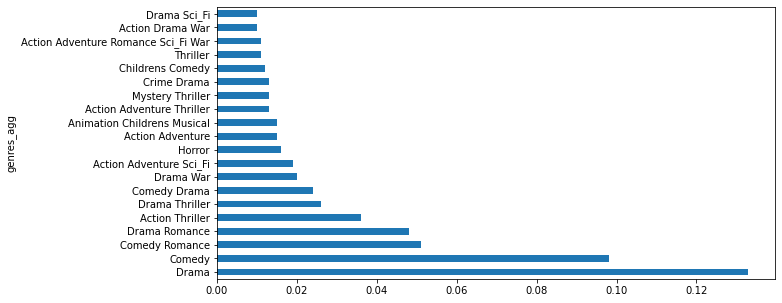

In [14]:

geners_comb_df=data[['genres_agg','user_id']].groupby('genres_agg').count().sort_values(by='user_id',ascending=False)
geners_comb_df['user_prec']=round(geners_comb_df/geners_comb_df['user_id'].sum(),3)
geners_comb_df['user_prec'].head(20).plot(kind='barh',figsize=(10,5))


Now we would like to demnostrate the bias of ratings when aggregating items with multiple genres under the same group, for this use case lets use the genre with the highest # of ratings = Drama.

,rating
genres_agg,
Drama,3.69254


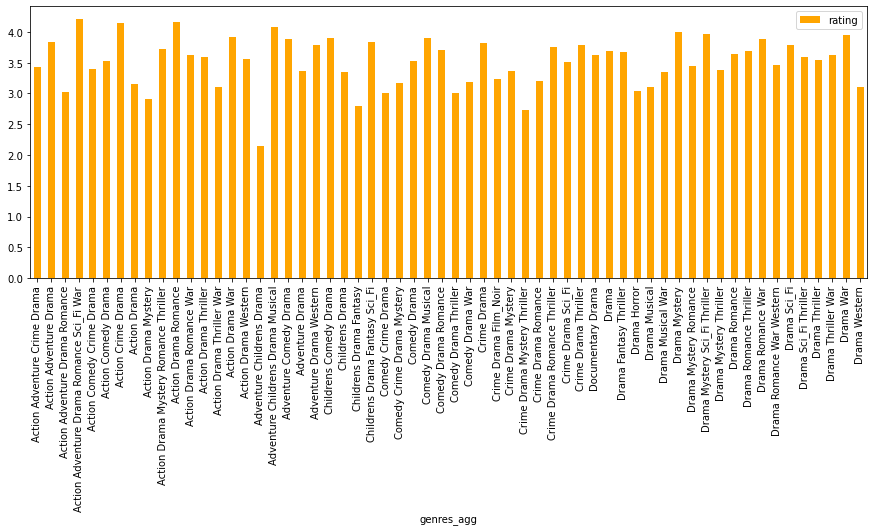

In [15]:
df_=data.loc[data['Drama']!=0][['genres_agg','rating']].groupby('genres_agg').mean().sort_values(by='genres_agg')

df_.plot(kind='bar',figsize=(15,5),color='orange')
df_[df_.index=='Drama']

In conclusion, from the given use case it is clear to see the difference between expected ranks for given combinations of genres that includes the genre drama. 

we should take this fact into consideration when searching for dimensions similarity.

## Title Exploration

Text(0.5, 1.0, '% of titles per #ranks')

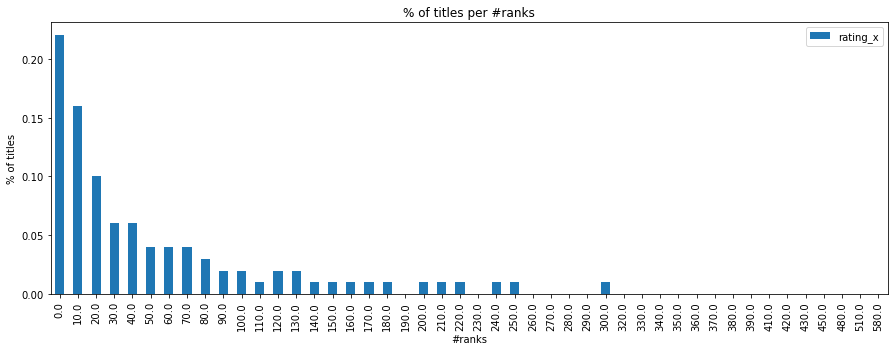

In [16]:

title_cnt=data[['title','rating']].groupby('title').count().sort_values(by='rating',ascending=False)
title_mean=data[['title','rating']].groupby('title').mean().sort_values(by='rating',ascending=False)
title_df=pd.merge(title_cnt,title_mean,on='title',how='inner')

title_df['#ranks']=round((round((title_df['rating_x']/100),1)*100),0).values
round(title_df[['#ranks','rating_x']].groupby('#ranks').count()/title_df.shape[0],2).plot(kind='bar',figsize=(15,5))
plt.ylabel('% of titles')
plt.title('% of titles per #ranks')
# data['title'].hist(by=None, bins=10)



* 32% of the titles has less than 10 ranks
* 80% of the titles has less than 100 ranks

**Text Exploration**

One of the popular tools for text data exploration is word cloud. Other options may include word distribution. 

Add a plots for your analysis and describe your insights. 

(-0.5, 999.5, 399.5, -0.5)

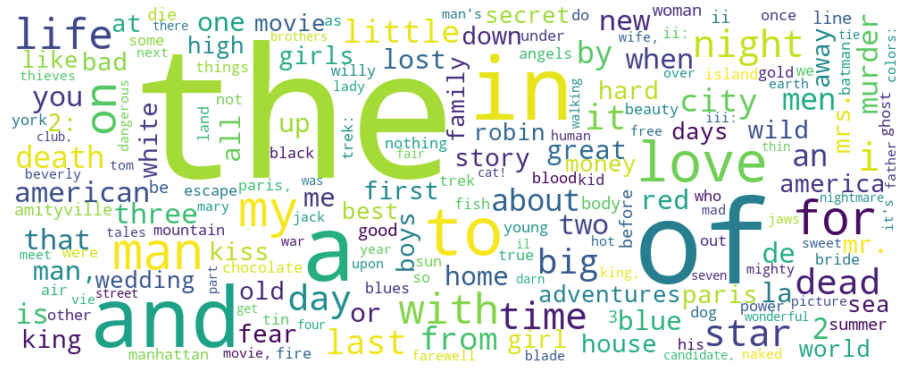

In [17]:
word_popularity = (df_movies.title.str.split(' ')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))

genre_wc = WordCloud(width=1000,height=400,background_color='white')
genre_wc.generate_from_frequencies(word_popularity.to_dict())
plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')


<br><br><br><br><br><br>
# Question 2:
# Item Similarity

The following blog posts [link1](https://medium.com/@bindhubalu/content-based-recommender-system-4db1b3de03e7), [link2](https://towardsdatascience.com/movie-recommendation-system-based-on-movielens-ef0df580cd0e), will be helpful for answering questions 2 and 3. 

Please answer, code, and explain your answer.  
In case you don't have a clear answer, please mention your hypothesis.

### Build a movie profile vector based on the item features of your choice. 
Select at least two features. Discuss the contribution of each feature
Tip: When looking on the MovieLens dataset it's features vector will include `genres`, `title`, etc.

we created vector that contains genres & titles as movie content related features.
* Genres - The motivation is to locate similar genres vectors and calculate similarity.
* Title - The motivation is to locate movies with common leading words within the titles.

Initialy lets define movie/item profile

In [18]:
#we will use df_movies as our profiler which constructed at exploration phase
columns_to_drop=['video_release_date','IMDb_URL','release_date','movie_title']+cols_genres
movie_profile = df_movies.drop(columns_to_drop,axis=1)
movie_profile=movie_profile.set_index('item_id')
movie_profile.head()

,genres_agg,title,features_vector
item_id,,,
1,Animation Childrens Comedy,toy story,Animation Childrens Comedy toy story
2,Action Adventure Thriller,goldeneye,Action Adventure Thriller goldeneye
3,Thriller,four rooms,Thriller four rooms
4,Action Comedy Drama,get shorty,Action Comedy Drama get shorty
5,Crime Drama Thriller,copycat,Crime Drama Thriller copycat


Lets apply TF-IDF in order to provide weight values and apply cosin-sim on both features

In [19]:
#TF-IDF for features vector
def tf_idf(movie_profile,fatures_col): 
    tfidfvec = TfidfVectorizer()
    tfidf_matrix = tfidfvec.fit_transform((movie_profile[fatures_col]))

    tfidf_df=pd.DataFrame(tfidf_matrix.todense(), columns=tfidfvec.get_feature_names(), index=movie_profile.index)
    return tfidf_df

### Build a function which provides the 5 most similar items to a specific item. 
Please use `Cosine Similarity` metric to calculate Item to item similarity.


**Motivation - we want to account superset of genres/words for a given item(movie), TF-IDF vectorizer will take into account how frequent the combinations are among all movies. Following that we will use cosine similarity as our proximity measure in order to return top n similar item in descending order**


In [20]:
def get_similar_items(movie_profiles,item_id,n=5): # you can add no_self=True for debbuging
    ''' 
    movie_profiles: movie profiles of all candidate movies
    item_id : target item 
    n : number of similar items to return
    
    This function returns a dataframe\array with ids of n most similar items to the target item and the similarity score
    '''
    cosine_sim = pd.DataFrame(cosine_similarity(movie_profiles),columns=movie_profiles.index,index=movie_profiles.index)

    top_sim_items=cosine_sim[item_id].sort_values(ascending=False).head(n+1)
    top_sim_items_df=pd.DataFrame(data=top_sim_items)
    
    return top_sim_items_df

### Use the above function to find the 5 most similar items for 2 items from the dataset. 
Please discuss the results you got. Are there any challenges? 

Please add the movie's title and image to your explanation.  (see example)

## Embedded Features - Genres & Titles

In [21]:
# helper function to display the similarity of the items' results
def display_item_sim(item_id, sim_genres):
    sim_genres = sim_genres.rename(columns={item_id: 'similar_score'})
    movies_sim=df_movies.set_index('item_id')
    movies_sim = movies_sim.loc[sim_genres.index].merge(sim_genres, on='item_id')

    genre_columns = cols_genres.copy()
    genre_columns.remove('unknown')

    for genre in genre_columns:
        movies_sim[genre] = pd.to_numeric(movies_sim[genre], errors='coerce').fillna(1).astype(np.int64)

    columns_to_present = ['similar_score', 'movie_title'] + genre_columns
    display(movies_sim[columns_to_present])


def display_movie_item_image(images_url):
    images = []
    for image_url in images_url:
        img = Image.open(requests.get(image_url, stream=True).raw)
        img = img.resize((200, 250))
        images.append(img)

    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = min(heights)

    movies_images = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    
    for im in images:
        movies_images.paste(im, (x_offset,0))
        x_offset += im.size[0]

    display(movies_images)

####################################
##### get_movie_image_by_title #####
############ NOT IN USED ###########
####################################

# import urllib.request
# import re
# import urllib

# # Display movies' images by title
# def get_movie_image_by_title(m_title):  # e.g. m_title = 'Toy Story (1995)'    
#     m_title = urllib.parse.quote(m_title)
#     movie_site = f'https://www.imdb.com/find?q={m_title}'

#     website = urllib.request.urlopen(movie_site)
#     html = website.read()
#     pat = re.compile(rb'<img [^>]*src="([^"]+)')
#     img_urls = pat.findall(html)

#     movie_image = Image.open(requests.get(img_urls[0], stream=True).raw)
#     return movie_image

In [22]:
tfidf_df=tf_idf(movie_profile,'features_vector')

example 1:

,similar_score,movie_title,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
item_id,,,,,,,,,,,,,,,,,,,,
95,1.000000,Aladdin (1992),0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
422,0.602103,Aladdin and the King of Thieves (1996),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
501,0.490778,Dumbo (1941),0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
993,0.484992,Hercules (1997),0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
418,0.477439,Cinderella (1950),0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
432,0.477439,Fantasia (1940),0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


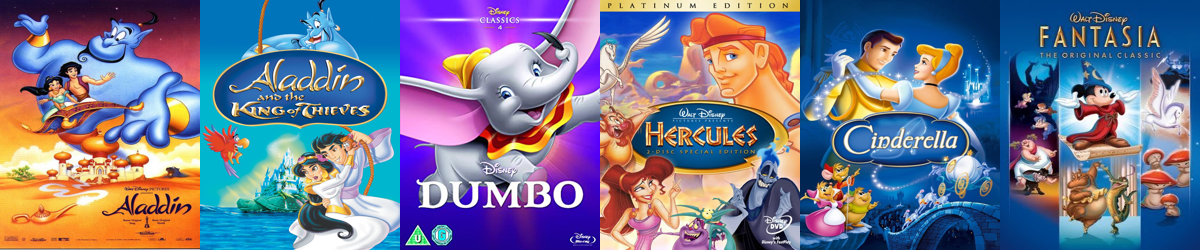

In [23]:
item_id = 95
sim_genres=get_similar_items(tfidf_df,item_id,n=5)
display_item_sim(item_id, sim_genres)

images_url = ['https://images.fandango.com/ImageRenderer/0/0/redesign/static/img/default_poster.png/0/images/masterrepository/Fandango/56153/aladdin.jpg',
              'https://www.themoviedb.org/t/p/original/kTH7qEyvdDYMoQraQZm3LFKCge3.jpg',
              'https://m.media-amazon.com/images/I/8132sG1vcBL._AC_SX342_.jpg', 
              'https://static.wikia.nocookie.net/english-voice-over/images/8/84/Hercules_1997_DVD_Cover.PNG/revision/latest?cb=20160108223932&path-prefix=sv', 
              'https://www.themoviedb.org/t/p/w500/4nssBcQUBadCTBjrAkX46mVEKts.jpg', 
              'https://play-lh.googleusercontent.com/h2D7u-7JOG6-Xn6zCPVs6RNNLSAjF5FsV_59D6xUAQnunPMnFwIezsdPzfzBoorpxClE']

display_movie_item_image(images_url)

Example 2:

,similar_score,movie_title,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
item_id,,,,,,,,,,,,,,,,,,,,
100,1.000000,Fargo (1996),0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
656,0.342290,M (1931),0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
129,0.302938,Bound (1996),0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0
1069,0.299827,Amateur (1994),0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
5,0.299827,Copycat (1995),0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
11,0.290107,Seven (Se7en) (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


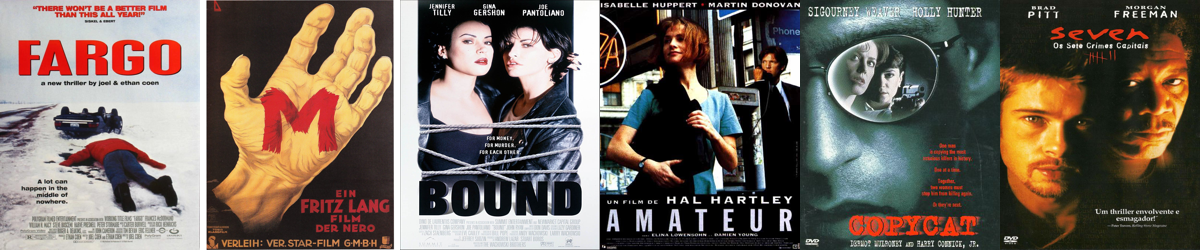

In [24]:
item_id = 100
sim_genres=get_similar_items(tfidf_df,item_id,n=5)
display_item_sim(item_id, sim_genres)

images_url = ['https://pics.filmaffinity.com/Fargo-790243981-large.jpg',
              'http://themovieshelf.com/wp-content/uploads/2018/09/IMG_3499.jpg',
              'https://i.pinimg.com/originals/d8/24/87/d824871b37fe0115b682aaa926237d86.jpg', 
              'https://pics.filmaffinity.com/Amateur-312810159-large.jpg', 
              'https://m.media-amazon.com/images/M/MV5BMjE3NTgxMDM2MF5BMl5BanBnXkFtZTYwNzc4MDY5._V1_.jpg', 
              'https://m.media-amazon.com/images/M/MV5BZDgyZmY5MmItY2I3Ny00NjA4LWFhNmItMGQ4ZGJhZDk5YjU3XkEyXkFqcGdeQXVyMTAzMDM4MjM0._V1_.jpg']

display_movie_item_image(images_url)

Discussion - Due to the fact we applied detailed features vectors with all genres combinations + titles as additional content features the recommended movies + similarity score on higher granularity level.

Yet, we do need to handle in case of a items tie and the offered model doesnt offer a solution for that.

A possible solution in case of a tie is to order the items by second level of avg_rank or adding additional feature to the feature vector.

<br><br><br><br><br><br>
# Question 3:
# Content based recommendation



### Build a function which recommends 5 most relevant items to a user. 

Based on: https://towardsdatascience.com/movie-recommendation-system-based-on-movielens-ef0df580cd0e

In [25]:
def get_item_recommendations(users_profile, movie_profile):
    tfidf_df = tf_idf(movie_profile,'features_vector')
    user_profile = pd.DataFrame(columns = tfidf_df.columns)

    user_ratings = train.T
    user_ratings.replace(0, np.NaN, inplace=True)
    col = user_ratings.columns

    for i in range(len(col)):
        working_df = tfidf_df.mul(user_ratings.iloc[:, i], axis=0)
        user_profile.loc[col[i]] = working_df.mean(axis=0)

    cosine_similarity_calc = cosine_similarity(user_profile, tfidf_df)
    cosine_similarity_calc_df = pd.DataFrame(cosine_similarity_calc, 
                                             columns=range(1, movie_profile.shape[0] + 1), 
                                             index=range(1, user_profile.shape[0] + 1))
    return cosine_similarity_calc_df

def get_item_recommendations_per_user(user_id, cosine_similarity_calc_df, top_n=5):
    recommended_results = cosine_similarity_calc_df.iloc[user_id, :].sort_values(ascending=False).head(top_n)
    recommended_items_ids, recommended_items_score = recommended_results.index, recommended_results.values
    return recommended_items_ids, recommended_items_score

In [26]:
user_profile = pd.DataFrame(columns = tfidf_df.columns)
recommendations_output_df = get_item_recommendations(user_profile, movie_profile)

### Test 1:

In [27]:
top_n = 5
user_id = 3
item, score = get_item_recommendations_per_user(user_id, recommendations_output_df, top_n=5)

print('User = {}\nTop {} Recommendaed items={}\nwith the scores = {}'.format(user_id, top_n, item, score))

User = 3
Top 5 Recommendaed items=Int64Index([260, 361, 356, 11, 327], dtype='int64')
with the scores = [0.3998648  0.38081828 0.3804345  0.36144227 0.35565145]


In [28]:
movie_profile[movie_profile.index.isin(item)]

,genres_agg,title,features_vector
item_id,,,
11,Crime Thriller,seven,Crime Thriller seven
260,Action Mystery Sci_Fi Thriller,event horizon,Action Mystery Sci_Fi Thriller event horizon
327,Crime Drama Mystery,cop land,Crime Drama Mystery cop land
356,Drama Mystery Thriller,"client, the","Drama Mystery Thriller client, the"
361,Crime Thriller,incognito,Crime Thriller incognito


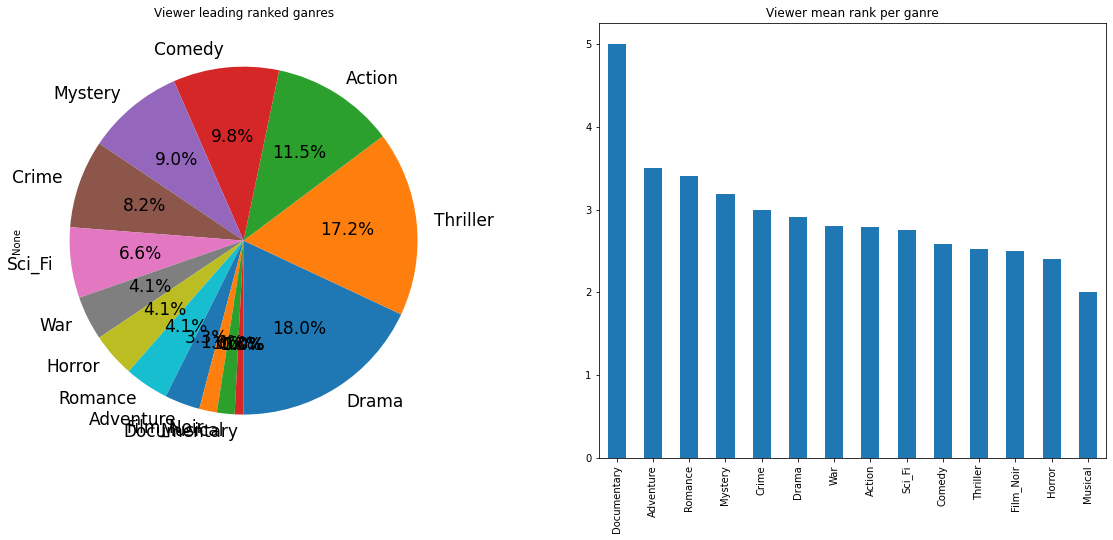

In [29]:
mask=data.user_id==3

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

data[mask][cols_genres].sum().sort_values(ascending=False).plot(kind='pie',ax=ax1,autopct='%1.1f%%', startangle=270, fontsize=17)
ax1.set_title('Viewer leading ranked ganres')

d=data[mask][['rating']+cols_genres]
for col in cols_genres:
    d[col]=d[col]*d['rating']    
    
d[cols_genres].replace(0, np.nan).mean().dropna().sort_values(ascending=False).plot(kind='bar',ax=ax2)
ax2.set_title('Viewer mean rank per ganre')

plt.show()

In this use case the user mostly ranked Drama|Thriller|Action movies although the highest ranks are for docu. 

According to the prediction output we do see all movies has Thriller as leading genre. 

### Test 2:

In [30]:
top_n = 5
user_id = 22
item, score = get_item_recommendations_per_user(user_id, recommendations_output_df, top_n=5)

print('User = {}\nTop {} Recommendaed items={}\nwith the scores = {}'.format(user_id, top_n, item, score))

User = 22
Top 5 Recommendaed items=Int64Index([1058, 181, 50, 49, 172], dtype='int64')
with the scores = [0.48703677 0.46170474 0.46054669 0.43095738 0.41880304]


In [31]:
movie_profile[movie_profile.index.isin(item)]

,genres_agg,title,features_vector
item_id,,,
49,Comedy Romance,i.q.,Comedy Romance i.q.
50,Action Adventure Romance Sci_Fi War,star wars,Action Adventure Romance Sci_Fi War star wars
172,Action Adventure Drama Romance Sci_Fi War,"empire strikes back, the",Action Adventure Drama Romance Sci_Fi War empi...
181,Action Adventure Romance Sci_Fi War,return of the jedi,Action Adventure Romance Sci_Fi War return of ...
1058,Adventure Drama,"war, the","Adventure Drama war, the"


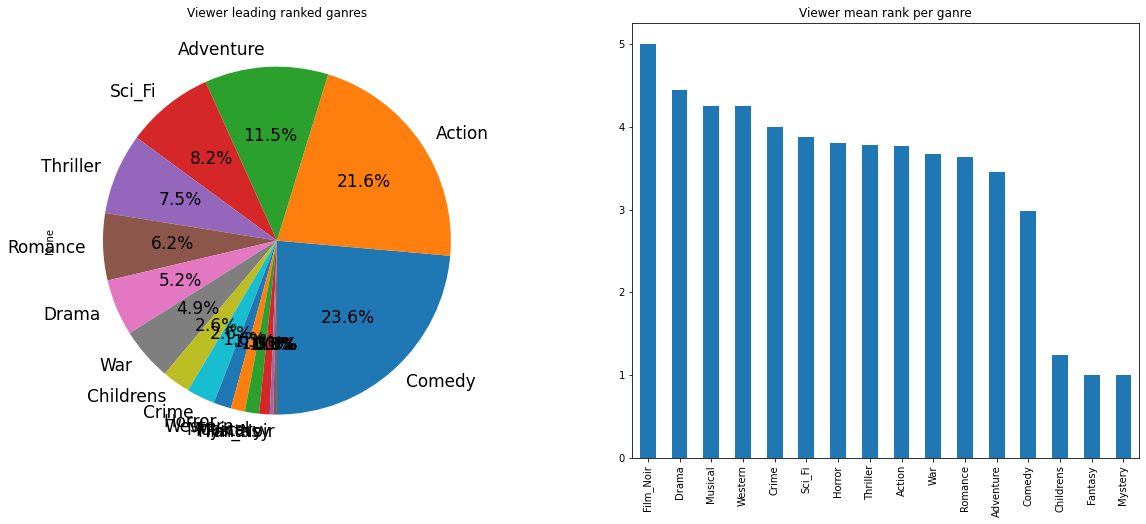

In [32]:
mask=data.user_id==22

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

data[mask][cols_genres].sum().sort_values(ascending=False).plot(kind='pie',ax=ax1,autopct='%1.1f%%', startangle=270, fontsize=17)
ax1.set_title('Viewer leading ranked ganres')

d=data[mask][['rating']+cols_genres]
for col in cols_genres:
    d[col]=d[col]*d['rating']    
    
d[cols_genres].replace(0, np.nan).mean().dropna().sort_values(ascending=False).plot(kind='bar',ax=ax2)
ax2.set_title('Viewer mean rank per ganre')

plt.show()

In this use case the user mostly ranked Comedy|Adventure|Action movies although the highest ranks are for Film_Noir.

According to the prediction output we do see all movies has Adventure as leading genre but only 1 tagged as comedy which might be FN from the prediction side. 

### Use the MRR metric to evaluate your recommender system on the test set. 
Use a cutoff value of 5.

In [33]:
# MRR computation
def MRR(df_true, df_pred, top_n=5):
    mrr_vals = []
    
    for i in range(len(df_true)):
        user_mrr = MRR_for_user(df_true[i], df_pred[i], top_n=top_n)
        if user_mrr > 0:
            mrr_vals.append(user_mrr)
    return np.mean(mrr_vals)
    

def MRR_for_user(user_true, user_pred, top_n=5):
    user_pred = user_pred[user_true.nonzero()]
    user_true = user_true[user_true.nonzero()]
    index = np.argsort(-user_pred)

    for rank, item in enumerate(index[:top_n]):
        if user_true[item] >= 3:
            return 1.0 /(rank + 1.0)
    return 0

# RMSE computation - relevant for the last section
def RMSE(actual, pred, lower_bound=1, upper_bound=5):
    pred = pred[actual.nonzero()]
    actual = actual[actual.nonzero()]
    pred[pred < lower_bound] = lower_bound
    pred[pred > upper_bound] = upper_bound
    return np.sqrt(np.nanmean((actual - pred)**2))

In [34]:
mrr_res = MRR(test.values, recommendations_output_df.values, top_n=5)
print(f'MRR Metric Evaluation Result: {mrr_res}')

MRR Metric Evaluation Result: 0.9370570107858243


<br><br><br><br><br>
# Question 4
# Content based recommendations vs. Matrix Factorization

### Use MF's  item representation to find the most similar items
Use the matrix factorization item representation you built in exercise 1 to find the most similar items for **the same 2 items** you used above. 
(Use your optimal hyperparams)

Compare the results you got using the different methods. Discuss your findings

In [35]:
# MF class
class MF:

    def __init__(self, df_train, n_factors=10, only_bias=False):
        self.df_train = df_train
        self.n_factors = n_factors
        self.only_bias = only_bias

        # initialize final matrix result
        self.output_matrix = np.zeros(df_train.shape)

        # rows==users , cols==items
        self.n_rows, self.n_cols = df_train.shape

        # biases
        self.original_bias_global = np.sum(df_train) / np.count_nonzero(df_train)
        self.original_bias_rows = np.sum(df_train, axis=1) / np.count_nonzero(df_train, axis=1)
        self.original_bias_cols = np.sum(df_train, axis=0) / np.count_nonzero(df_train, axis=0)

        # "reset" initialization
        self.initialize_params()

    def initialize_params(self):
        if self.only_bias:
            self.U = None
            self.V = None
        else:
            # randomly initialize matrices U and V
            self.U = np.random.rand(self.n_rows, self.n_factors)
            self.V = np.random.rand(self.n_cols, self.n_factors)

        # initialize bias
        self.bias_global = self.original_bias_global  # no need to learn it
        self.bias_rows = np.random.rand(self.n_rows)  # random
        self.bias_cols = np.random.rand(self.n_cols)  # random

    def fit(self,
            n_iterations=1,
            learning_rate=1e-1,
            regularization=1e-2,
            convergence=1e-5,
            error='RMSE',
            initialize_training=True,
            verbose=True):

        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error

        if initialize_training:
            self.initialize_params()

        # please record your progress in history
        self.history = []

        # please record the training time in fit_time
        start_time = time.time()

        # create nonzero observed data list
        rows_indices, cols_indices = np.nonzero(self.df_train)
        self.S = list(zip(rows_indices, cols_indices))

        # iterate until convergence/number of iterations
        for current_iteration in range(self.n_iterations):
            # compute the output matrix for evaluation
            self.output_matrix = self.get_output_matrix()

            # store the mse history for visualization
            self.history.append(self.get_rmse(self.df_train))

            # printing
            if verbose:
                print('iteration: ', current_iteration, ' total error:\n', self.history[-1])

            # convergence
            if current_iteration != 0 and self.converging():
                if verbose:
                    print('converged...')
                break

            # randomly shuffle observed entries in S
            np.random.shuffle(self.S)

            # perform GD optimization
            self.optim_GD()
        
        self.output_matrix = self.get_output_matrix()
        self.fit_time = time.time() - start_time

    def converging(self):
        if len(self.history) > 1:
            if self.history[-2] - self.history[-1] < self.ϵ:
                return True
        return False

    def optim_GD(self):
        """
        Stochastic Gradient Descent
        """
        for i, j in self.S:
            predicted_rating = self.predict_rating(i, j)
            e = self.df_train[i, j] - predicted_rating

            # compute updated biases
            self.bias_rows[i] += self.α * (e - self.λ * self.bias_rows[i])
            self.bias_cols[j] += self.α * (e - self.λ * self.bias_cols[j])

            if not self.only_bias:
                # compute updated users and items
                self.U[i, :] += self.α * (e * self.V[j, :] - self.λ * self.U[i, :])
                self.V[j, :] += self.α * (e * self.U[i, :] - self.λ * self.V[j, :])

    def predict(self, N=10):
        output_matrix = self.output_matrix
        prediction = np.argsort(output_matrix, axis=1)[-N:]
        return prediction

    def predict_rating(self, row, col):
        prediction = self.bias_global + self.bias_rows[row] + self.bias_cols[col]
        if not self.only_bias:
            prediction += self.U[row, :] @ self.V[col, :].T
        return prediction

    def get_rmse(self, test):
        return RMSE(test, self.output_matrix)
    
    def get_mrr(self, test, k=10, threshold=3):

        return MRR(test, self.output_matrix, top_n=k)

    def get_output_matrix(self):
        output_matrix = self.bias_global + self.bias_rows[:, np.newaxis] + self.bias_cols[np.newaxis:, ]
        if not self.only_bias:
            output_matrix += self.U @ self.V.T
        return output_matrix

In [36]:
# function using the MF class 
def get_MF_similar_items(mf_model, item_id, top_n=5):
    mf_matix_df = pd.DataFrame(mf_model.output_matrix)
    return get_similar_items(mf_matix_df, item_id, n=top_n)

In [37]:
# MF fit train
mf_model = MF(np.nan_to_num(train.copy()), n_factors=20)
mf_model.fit(n_iterations=4,learning_rate=0.01,regularization=0.1,convergence=0.00001, verbose=False)

### find similar items to the same two items you choose

#### Item Id: 95 - Aladdin (1992)	

In [38]:
item_id = 95
mf_similar_items = get_MF_similar_items(mf_model, item_id, top_n=5)
mf_similar_items.index.name = 'item_id'
df_movies[['item_id', 'movie_title']].merge(mf_similar_items, on='item_id') \
    .rename(columns={item_id: 'similar_score'}) \
    .sort_values(by=['similar_score'], ascending=False)

,item_id,movie_title,similar_score
3,95,Aladdin (1992),1.000000
4,232,Young Guns (1988),0.998542
2,72,"Mask, The (1994)",0.998364
5,391,Last Action Hero (1993),0.998353
1,29,Batman Forever (1995),0.998333
0,5,Copycat (1995),0.998313


#### Similarity by genre

In [39]:
# display the similarity by genre for item_id 95
display_item_sim(item_id, mf_similar_items)

,similar_score,movie_title,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
item_id,,,,,,,,,,,,,,,,,,,,
95,1.000000,Aladdin (1992),0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
232,0.998542,Young Guns (1988),1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
72,0.998364,"Mask, The (1994)",0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0
391,0.998353,Last Action Hero (1993),1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
29,0.998333,Batman Forever (1995),1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0.998313,Copycat (1995),0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


#### Item Id: 100 - Fargo (1996)

In [40]:
item_id = 100
mf_similar_items = get_MF_similar_items(mf_model, item_id, top_n=5)
mf_similar_items.index.name = 'item_id'
df_movies[['item_id', 'movie_title']].merge(mf_similar_items, on='item_id') \
    .rename(columns={item_id: 'similar_score'}) \
    .sort_values(by=['similar_score'], ascending=False)

,item_id,movie_title,similar_score
2,100,Fargo (1996),1.000000
0,42,Clerks (1994),0.997836
5,805,Manhattan Murder Mystery (1993),0.997793
3,378,Miracle on 34th Street (1994),0.997397
1,57,Priest (1994),0.997314
4,639,"Tin Drum, The (Blechtrommel, Die) (1979)",0.997278


#### Similarity by genre

In [41]:
# display the similarity by genre for item_id 100
display_item_sim(item_id, mf_similar_items)

,similar_score,movie_title,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
item_id,,,,,,,,,,,,,,,,,,,,
100,1.000000,Fargo (1996),0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
42,0.997836,Clerks (1994),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
805,0.997793,Manhattan Murder Mystery (1993),0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
378,0.997397,Miracle on 34th Street (1994),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
57,0.997314,Priest (1994),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
639,0.997278,"Tin Drum, The (Blechtrommel, Die) (1979)",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Findings Discussion

Matrix factorization is used for identifying the relationship between items' and users' entities. It is generally effective because it allows the system to discover the underlying characteristics of interactions between users and items.

However, according to our results above, when using the similarity computation between <b>item-to-item</b> entities, we're getting insufficient results compared to our content-based model. It seems that it can be improved if we would add additional information to each item (such as genre, title, etc.).

The Content-Based model provided us more reliable recommendations according to the desired item. For instance, if we chose a Disney/animation movie, it also recommended us this specific type of movie (which makes more sense with regards to our input item).

### Compare the results of the content based recommender system to the matrix factorization recommender system

- Please use the same train and test set. 
- Please use the MRR metric for the comparison (use plot). 

In [42]:
cb_mrr_res = MRR(test.values, recommendations_output_df.values, top_n=5)
print(f'Content-Based MRR Metric Evaluation Result: {cb_mrr_res}')

Content-Based MRR Metric Evaluation Result: 0.9370570107858243


In [43]:
mf_mrr_res = MRR(test.values, mf_model.output_matrix, top_n=5)
print(f'MRR Metric Evaluation Result: {mf_mrr_res}')

MRR Metric Evaluation Result: 0.9488461538461539


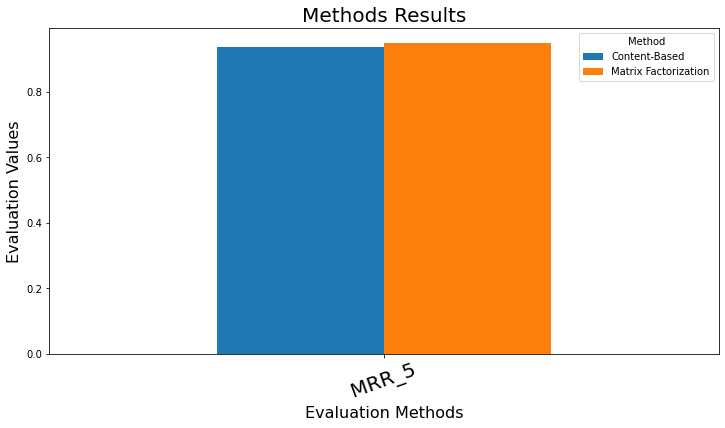

In [44]:
# visuzalization 
final_results = pd.DataFrame(columns=['Method', 'MRR_5'])
final_results.loc[len(final_results)] = 'Content-Based', cb_mrr_res
final_results.loc[len(final_results)] = 'Matrix Factorization', mf_mrr_res
final_results = final_results.set_index('Method')
final_results.T.plot(kind='bar', figsize=(12,6))

plt.title("Methods Results", fontsize=20)
plt.xlabel("Evaluation Methods", fontsize=16)
plt.ylabel("Evaluation Values", fontsize=16)
plt.xticks(fontsize=20, rotation=20)
plt.show()

### Findings Discussion

According to the result above, the MF model got slightly better MRR results compared to the CB model. However, the Content-based model still performed better in practice, based on the top 5 recommendations' types.

Content-based filtering does not require other users' data during recommendations to one user, while MF does not need the features of the items to be given, every user and item is described by a feature vector or embedding. 
* It considers other users’ reactions while recommending a particular user. 
* It notes which items a particular user likes and also the items that the users with behavior and likings like him/her likes, to recommend items to that user.
* It collects user feedbacks on different items and uses them for recommendations.

### Advantages & Disadvantages 

Please use the following table to discuss the advantages and disadvantages of matrix factorization vs. content based recommender systems.
In your discussion please make sure to each of these rows and more...

<table>
    <thead>
        <tr>
            <th>..</th>
            <th style="text-align:center">Content-Based</th>
            <th style="text-align:center">Matrix-Factorization</th>
            <th style="text-align:left">Notes:</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Dimensionality</td>
            <td style="text-align:center">Performs dimensional Reduction</td>
            <td style="text-align:center">Performs dimensional Reduction</td>
            <td style="text-align:left">MF compresses the large interaction matrix using dimensional Reduction (latent vectors). CB provides recommendations according to this dimensionally-reduced feature profile.</td>
        </tr>
        <tr>
            <td>Similarity</td>
            <td style="text-align:center">Performs Item to Item Similarity</td>
            <td style="text-align:center">Performs User to Item Similarity</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Accuracy</td>
            <td style="text-align:center">Considered less accurate</td>
            <td style="text-align:center">Considered more accurate</td>
            <td style="text-align:left">CB: based on the item's entities (item profile), for example, choosing a movie title and the system will find a movie which has the most similar features.</td>
        </tr>
        <tr>
            <td>Training Complexity</td>
            <td style="text-align:center">Considered less complex</td>
            <td style="text-align:center">Considered more complex</td>
            <td style="text-align:left">MF attempts to achieve minimal error using an optimization algorithm.</td>
        </tr>
        <tr>
            <td>Inference Complexity</td>
            <td style="text-align:center">Considered with less Inference Complexity</td>
            <td style="text-align:center">Considered with more Inference Complexity</td>
            <td style="text-align:left">MF might have difficulties inferring conclusions, while CB can be more inferred according to the item's profile.</td>
        </tr>
        <tr>
            <td>Explanability</td>
            <td style="text-align:center">Considered more explanability</td>
            <td style="text-align:center">Considered less explanability</td>
            <td style="text-align:left">CB can provide highly interpretable insights.</td>
        </tr>
        <tr>
            <td>Scalability</td>
            <td style="text-align:center">Has scalability issues</td>
            <td style="text-align:center">Has scalability issues</td>
            <td style="text-align:left">CB, Every time a new product or service or new content is added, its attributes must be defined and tagged. The never-ending nature of attribute assignments can make scalability difficult and time-consuming. However, it is not dependent on an additional user's input, hence more scalable to a large number of users.</td>
        </tr>        
        <tr>
            <td>New User</td>
            <td style="text-align:center">Has the user cold-start problem</td>
            <td style="text-align:center">Has the user cold-start problem</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>New Item</td>
            <td style="text-align:center">Suitable for new items</td>
            <td style="text-align:center">Has the item cold-start problem</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Train Time</td>
            <td style="text-align:center">Contains less training time</td>
            <td style="text-align:center">Contains more training time</td>
            <td style="text-align:left">MF might contain more training time, depends on the number of iteration.</td>
        </tr>
        <tr>
            <td>Predict Time</td>
            <td style="text-align:center">Fast</td>
            <td style="text-align:center">Fast</td>
            <td style="text-align:left">CB & MF do not require performing an additional computation when performing a prediction.</td>
        </tr>
        <tr>
            <td>Randomness</td>
            <td style="text-align:center">Does not contain random variables</td>
            <td style="text-align:center">Contains random variables</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Trands</td>
            <td style="text-align:center">Considered as less suitable to trends</td>
            <td style="text-align:center">Handles trends</td>
            <td style="text-align:left">CB learns only for the specific user's interest, hence it doesn't benefit from other user's ratings. MF is based on multiple user inputs, hence can capture trends.</td>
        </tr>
        <tr>
            <td>Tradoff</td> 
            <td  style="text-align:center">Needs a domain expertise</td>
            <td style="text-align:center">Requires many ratings</td>
            <td style="text-align:left">CB is only as good as the subject-matter experts tagging items. Potentially millions of items may need attributes assigned, and since attributes can be subjective, many may be incorrectly tagged.</td>
        </tr>
    </tbody>
</table>

<br>

Good Luck :)